# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read data from .txt file
df = pd.read_csv('household_power_consumption.txt', sep=';')

# Viewing data
df.head()

/tmp/ipykernel_141382/3579485128.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Cleaning

In [3]:
def cleaning(data):
    # Remove Nan values from Sub_metering_3 column
    data.dropna(subset=['Sub_metering_3'], inplace=True)

    # Converting numerical data to float
    data[df.columns[2:]] = data[df.columns[2:]].astype(float)

    # Combining Date and Time to store into 1 column
    data['Date'] = data['Date'] + " " + data['Time']

    # Dropping Time column
    data.drop(columns=['Time'], inplace=True)

    # Converting Date column into datetime[ns] format
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')

    return data

In [4]:
data = cleaning(df)

In [5]:
data.head()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='Sub_metering_1', ylabel='Count'>

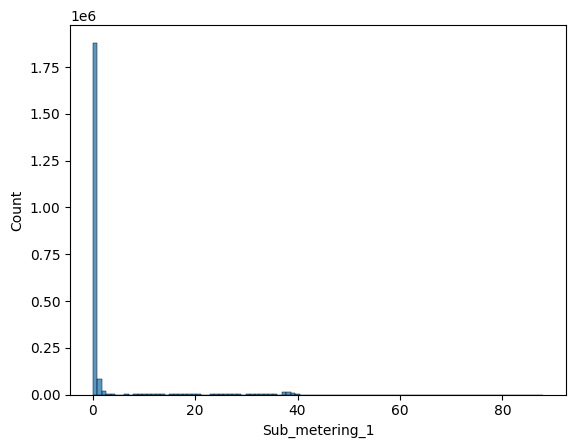

In [15]:
# Looking at distribution
sns.histplot(data=df['Sub_metering_1'], bins=100)

In [ ]:
sns.boxplot(x=df['Global_active_power'])

In [6]:
import scipy.stats

In [7]:
# Calculating Skewness values
skewness = scipy.stats.skew(data.drop(columns='Date'))

# Classifying each column's skewness

high_skew = [data.drop(columns='Date').columns[i] for i in range(len(skewness)) if (skewness[i] < - 1) or (skewness[i] > 1)]

In [8]:
print(high_skew)

['Global_active_power', 'Global_reactive_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']


In [9]:
# Defining different feature transformation functions

def log_transform(data, column):
    data[f'{column}_Log'] = np.log1p(data[column])
    return data

def sqrt_transform(data, column):
    data[f'{column}_Sqrt'] = np.sqrt(data[column])
    return data

def box_cox_transform(data, column):
    data[f'{column}_boxcox'] = scipy.stats.boxcox(data[column])
    return data

def reciprocal_transform(data, column):
    data[f'{column}_reciprocal'] = 1/ (data[column] + 1e-5)
    return data

def yeo_johnson_transform(data, column):
    from sklearn.preprocessing import PowerTransformer
    pt = PowerTransformer(method='yeo-johnson')
    data[f'{column}_yeo_johnson'] = pt.fit_transform(data[[column]])
    return data

def clipping_transform(data, column):
    upper_lim = data[column].quantile(0.95)
    data[f'{column}_clipping'] = np.where(data[column] > upper_lim, upper_lim, data[column])
    return data

def log_binning_transform(data, column):
    data[f'{column}_log_binning'] = pd.cut(np.log1p(data[column]), bins=5, labels=False)
    return data

In [ ]:
data['Global_active_power'].quantile(0.95)

In [10]:
transformations = {'Log': log_transform,
                   'Sqrt': sqrt_transform,
                   'reciprocal': reciprocal_transform,
                   'yeo_johnson': yeo_johnson_transform,
                   'clipping': clipping_transform,
                   'log_binning': log_binning_transform}

In [12]:
for transformer in transformations:
    print(f'{transformer} TRANSFORMATION')
    for col in high_skew:
        temp = transformations[transformer](data, col)
        temp_skew = scipy.stats.skew(temp[f'{col}_{transformer}'])
        original_skew = scipy.stats.skew(temp[col])
        print(f'{col}: Skewness = {original_skew}')
        print(f'{col}_{transformer}: Skewness = {temp_skew}')
    print('---------------------------------------')

Log TRANSFORMATION
Global_active_power: Skewness = 1.7862320846320818
Global_active_power_Log: Skewness = 0.7394033993766909
Global_reactive_power: Skewness = 1.261913273793962
Global_reactive_power_Log: Skewness = 0.9115075133976243
Global_intensity: Skewness = 1.8490985505960675
Global_intensity_Log: Skewness = 0.3904183310515181
Sub_metering_1: Skewness = 5.94453693037052
Sub_metering_1_Log: Skewness = 4.915854923426867
Sub_metering_2: Skewness = 7.090548040309821
Sub_metering_2_Log: Skewness = 3.2191752617720044
---------------------------------------
Sqrt TRANSFORMATION
Global_active_power: Skewness = 1.7862320846320818
Global_active_power_Sqrt: Skewness = 0.8051615682679741
Global_reactive_power: Skewness = 1.261913273793962
Global_reactive_power_Sqrt: Skewness = -0.22842416500773022
Global_intensity: Skewness = 1.8490985505960675
Global_intensity_Sqrt: Skewness = 0.8243679956703556
Sub_metering_1: Skewness = 5.94453693037052
Sub_metering_1_Sqrt: Skewness = 5.166511851159131
Sub_